In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from ood_detection_helper import *
from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import plotly as py
import plotly.graph_objs as go

import umap
from sklearn.preprocessing import MinMaxScaler 

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


'2.3.1'

## Loading OOD datasets

In [2]:
with open("scores.p", "rb") as f:
    score_dict = pickle.load(f)
score_dict.keys()

dict_keys(['train', 'test', 'mnist', 'cifar'])

In [18]:
train_scores = score_dict["train"]
inlier_scores = score_dict["test"]
outlier_scores = [score_dict["mnist"],score_dict["cifar"]]

In [19]:
LABELS = np.array(["Train", "F-MNIST", "MNIST", "CIFAR"])
COLORS = sns.color_palette("bright")

## Separation for lowest Sigma 

# Auxiliary model analysis

In [5]:
# Train Data = L2-norm(Pixel Scores)
X_train, X_test =  train_scores.copy(), inlier_scores.copy()

========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  1.5min finished


Best: 0.489306 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
-1.148391 (0.078888) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
-0.354701 (0.060292) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
-0.084772 (0.072762) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
0.084718 (0.066122) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
0.213739 (0.064709) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
0.305712 (0.061408) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
0.378093 (0.067919) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
0.417601 (0.058522) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
0.457247 (0.065177) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
0.489306 (0.064394) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


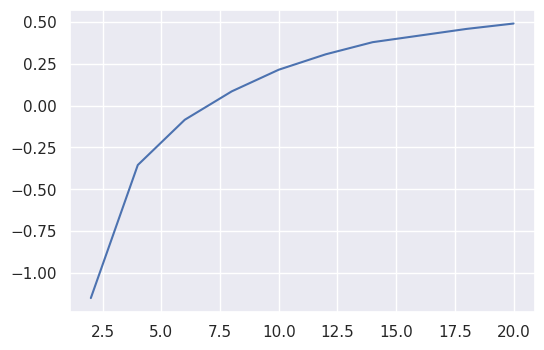

---Likelihoods---
Training: 0.515
F-MNIST: -2.847
MNIST: -9.206
========================= Training Flow Model =========================
Epoch 1/1000
468/468 [==============================] - 2s 5ms/step - loss: 215.9064 - val_loss: 165.5898
Epoch 2/1000
468/468 [==============================] - 2s 4ms/step - loss: 125.9874 - val_loss: 109.6841
Epoch 3/1000
468/468 [==============================] - 1s 2ms/step - loss: 92.0698 - val_loss: 84.0327
Epoch 4/1000
468/468 [==============================] - 1s 3ms/step - loss: 73.4813 - val_loss: 70.3094
Epoch 5/1000
468/468 [==============================] - 1s 2ms/step - loss: 62.5479 - val_loss: 63.2775
Epoch 6/1000
468/468 [==============================] - 1s 3ms/step - loss: 57.8480 - val_loss: 59.8714
Epoch 7/1000
468/468 [==============================] - 1s 2ms/step - loss: 54.7793 - val_loss: 57.4436
Epoch 8/1000
468/468 [==============================] - 1s 3ms/step - loss: 52.4572 - val_loss: 55.2072
Epoch 9/1000
468/468 [======

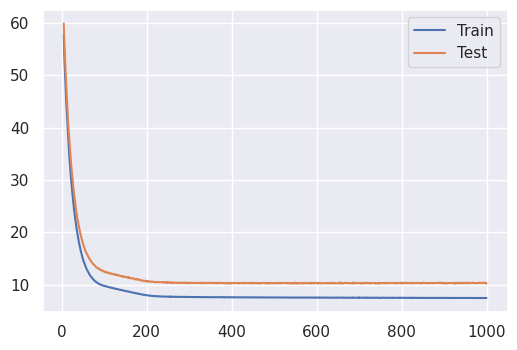

========================= Training KD Tree =========================
CPU times: user 49min 7s, sys: 18min 58s, total: 1h 8min 6s
Wall time: 34min 11s


In [6]:
%%time
results = auxiliary_model_analysis(X_train, X_test, outlier_scores, LABELS, flow_epochs=1000)

### GMM

In [8]:
results["GMM"]["metrics"]

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc
MNIST,77.382964,23.885,27.02,55.36,77.373731,84.354084,82.563428


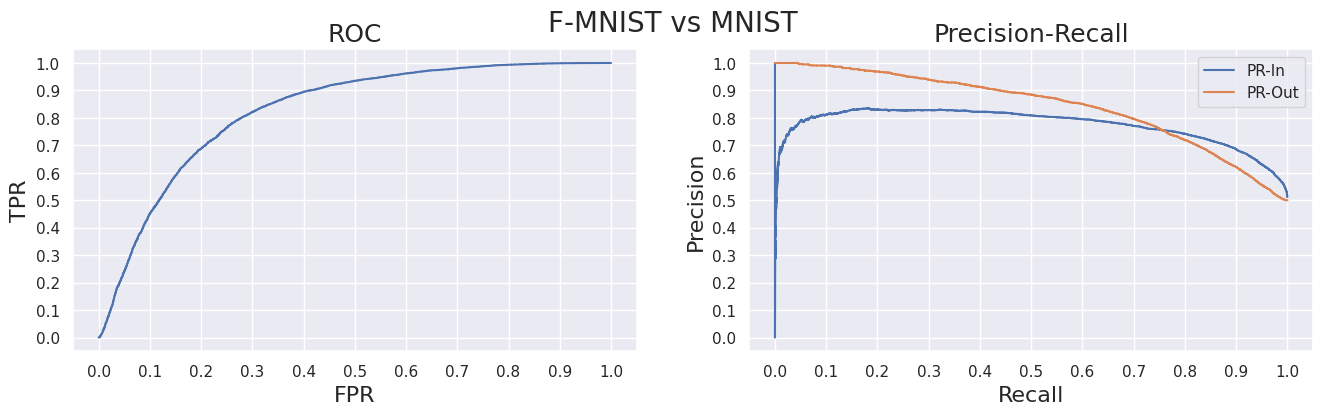

{'fpr_tpr95': 0.5536,
 'de': 0.23884999999999998,
 'roc_auc': 0.82563428,
 'pr_auc_in': 0.7737373109959471,
 'pr_auc_out': 0.8435408417534664,
 'fpr_tpr80': 0.2702,
 'ap': 0.7738296434387083}

F-MNIST vs MNIST
----------------
ROC-AUC: 82.5634
PR-AUC (In/Out): 77.3737 / 84.3541
FPR (95% TPR): 55.36%
Detection Error: 23.88%


In [10]:
ood_metrics(-results["GMM"]["test_scores"], -results["GMM"]["ood_scores"][0], names=(LABELS[1], LABELS[2]), plot=True, verbose=True)

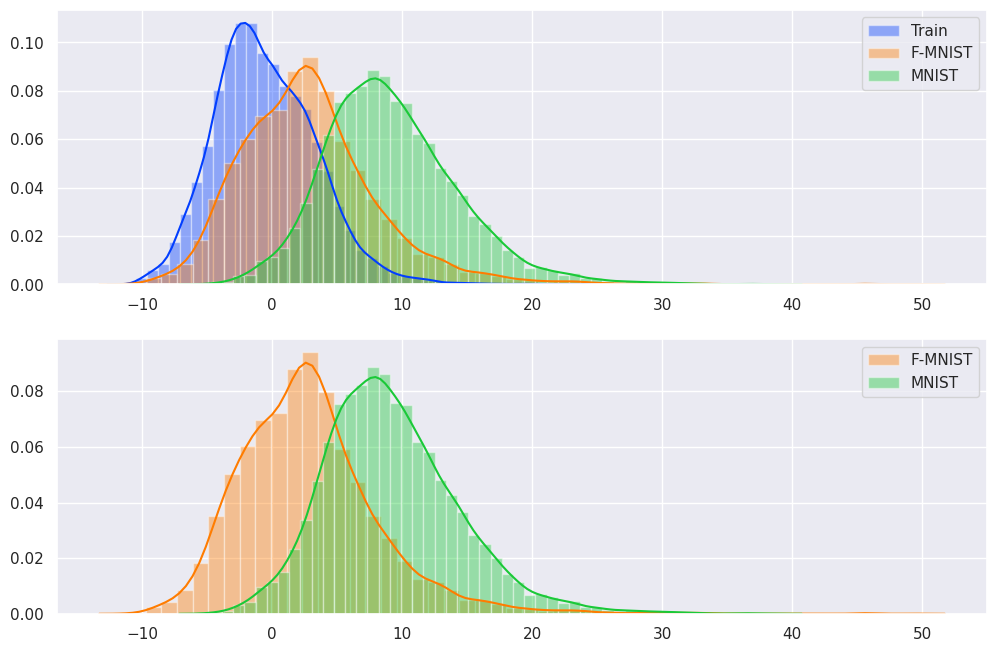

In [13]:
test_idxs=[0]
axs=evaluate_model(-results["GMM"]["train_scores"], -results["GMM"]["test_scores"],
               -results["GMM"]["ood_scores"][test_idxs], labels=LABELS)

### Validation Check

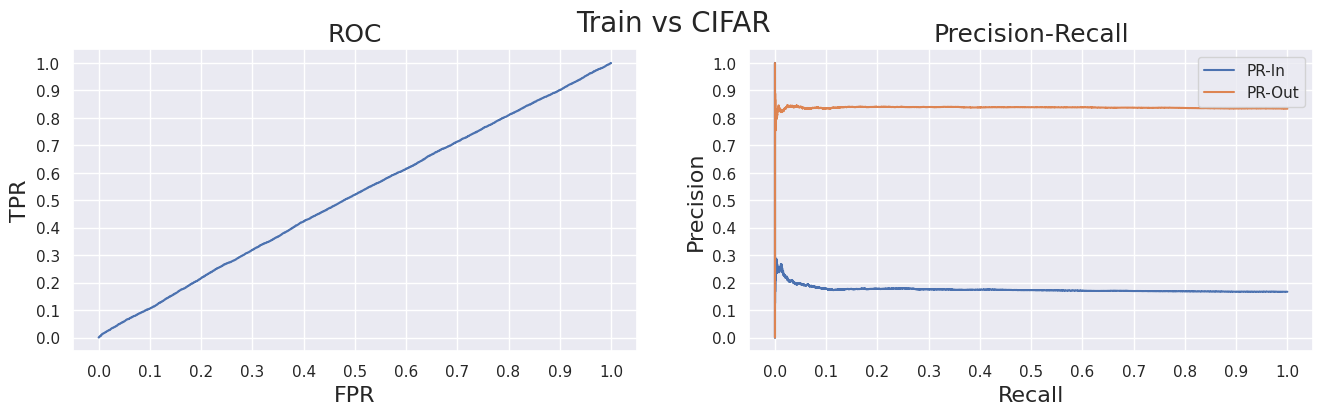

Train vs CIFAR
----------------
ROC-AUC: 51.2894
PR-AUC (In/Out): 17.4957 / 83.7403
FPR (95% TPR): 94.75%
Detection Error: 48.80%


{'fpr_tpr95': 0.94746,
 'de': 0.48797999999999997,
 'roc_auc': 0.512894474,
 'pr_auc_in': 0.17495683821073738,
 'pr_auc_out': 0.8374034887872269,
 'fpr_tpr80': 0.78028,
 'ap': 0.1750495543643971}

In [68]:
ood_metrics(-results["GMM"]["train_scores"], -results["GMM"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## Flow Models

In [14]:
results["Flow"]["metrics"]

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc
MNIST,80.827971,25.775,31.84,63.07,80.824064,82.060705,82.059041


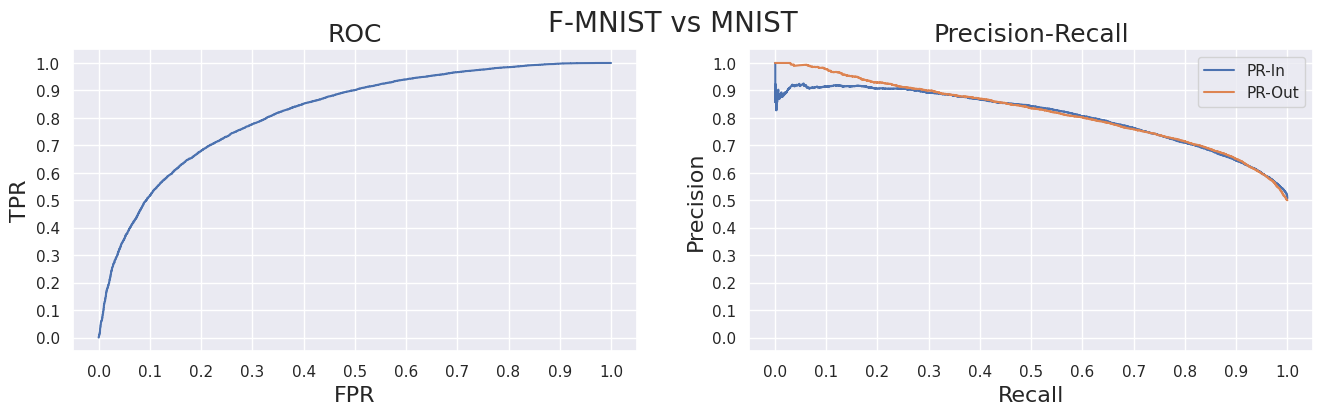

F-MNIST vs MNIST
----------------
ROC-AUC: 82.0590
PR-AUC (In/Out): 80.8241 / 82.0607
FPR (95% TPR): 63.07%
Detection Error: 25.78%


{'fpr_tpr95': 0.6307,
 'de': 0.25775000000000003,
 'roc_auc': 0.820590415,
 'pr_auc_in': 0.8082406358876109,
 'pr_auc_out': 0.8206070489863505,
 'fpr_tpr80': 0.3184,
 'ap': 0.8082797089755578}

In [15]:
ood_metrics(-results["Flow"]["test_scores"], -results["Flow"]["ood_scores"][0], names=(LABELS[1], LABELS[2]), plot=True, verbose=True)

### Validation Check

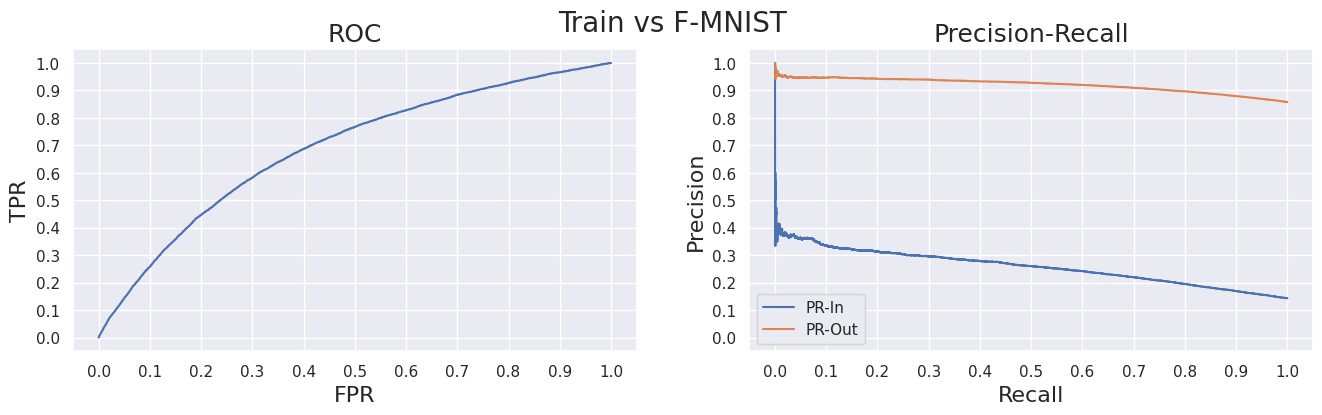

Train vs F-MNIST
----------------
ROC-AUC: 68.7121
PR-AUC (In/Out): 25.7516 / 92.0205
FPR (95% TPR): 85.42%
Detection Error: 35.53%


{'fpr_tpr95': 0.8542,
 'de': 0.35534166666666667,
 'roc_auc': 0.6871205283333333,
 'pr_auc_in': 0.2575159182445262,
 'pr_auc_out': 0.9202045354820635,
 'fpr_tpr80': 0.5366,
 'ap': 0.2576210269545275}

In [20]:
ood_metrics(-results["Flow"]["train_scores"], -results["Flow"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## KD Trees w/ k=5

In [33]:
def get_metrics(test_score, ood_scores, **kwargs):
    metrics = {}
    for idx, _score in enumerate(ood_scores):
        ood_name = LABELS[idx+2]
        metrics[ood_name] = ood_metrics(test_score, _score,
                                names=(LABELS[1], ood_name))
    metrics_df = pd.DataFrame(metrics).T * 100 # Percentages
    return metrics_df

print("====="*5 + " Training KD Tree " + "====="*5)

N_NEIGHBOURS = 5
nbrs = NearestNeighbors(n_neighbors=N_NEIGHBOURS, algorithm='kd_tree').fit(X_train)

kd_train_score, indices = nbrs.kneighbors(X_train)
kd_train_score = kd_train_score[...,-1] # Distances to the kth neighbour
kd_test_score, _ = nbrs.kneighbors(X_test)
kd_test_score = kd_test_score[...,-1]
kd_ood_scores = []
for ood in outlier_scores:
    dists, _ = nbrs.kneighbors(ood)
    kd_ood_scores.append(dists[...,-1]) 
kd_metrics = get_metrics(kd_test_score, kd_ood_scores)

kd_metrics

========================= Training KD Tree =========================


,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
MNIST,65.11,31.705,69.325459,58.434636,75.406525,43.27,58.440192
CIFAR,2.21,3.545,99.442095,99.461255,99.438420,0.23,99.461282


In [21]:
results["KD"]["metrics"]

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc
MNIST,58.440192,31.705,43.27,65.11,58.434636,75.406525,69.325459


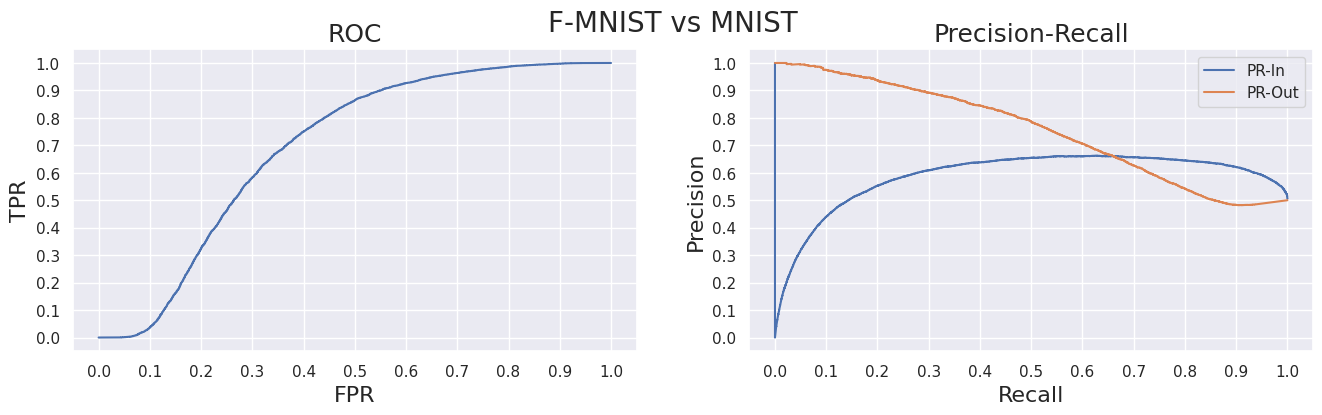

F-MNIST vs MNIST
----------------
ROC-AUC: 69.3255
PR-AUC (In/Out): 58.4346 / 75.4065
FPR (95% TPR): 65.11%
Detection Error: 31.70%


{'fpr_tpr95': 0.6511,
 'de': 0.31705,
 'roc_auc': 0.69325459,
 'pr_auc_in': 0.5843463598936867,
 'pr_auc_out': 0.7540652458921749,
 'fpr_tpr80': 0.4327,
 'ap': 0.5844019235527661}

In [17]:
ood_metrics(results["KD"]["test_scores"], results["KD"]["ood_scores"][0], names=(LABELS[1], LABELS[2]), plot=True, verbose=True)

### Validation Check

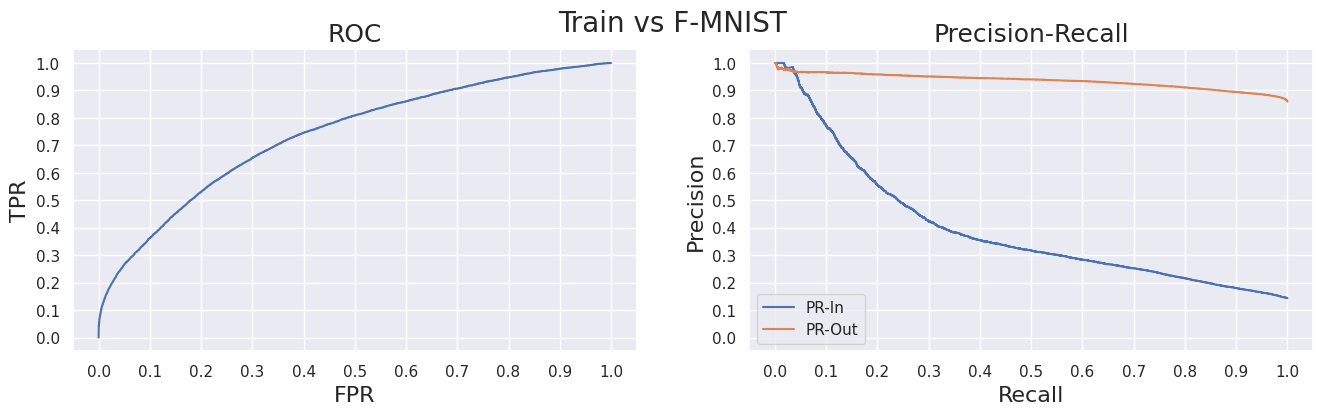

Train vs F-MNIST
----------------
ROC-AUC: 73.7743
PR-AUC (In/Out): 39.3978 / 93.4958
FPR (95% TPR): 80.43%
Detection Error: 32.22%


{'fpr_tpr95': 0.8042833333333334,
 'de': 0.32224166666666665,
 'roc_auc': 0.7377430516666666,
 'pr_auc_in': 0.3939782256698341,
 'pr_auc_out': 0.9349577806302715,
 'fpr_tpr80': 0.4705,
 'ap': 0.3940086602074549}

In [22]:
ood_metrics(results["KD"]["train_scores"], results["KD"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

In [23]:
for n in ["GMM", "Flow", "KD"]:
    print(results[n]["metrics"].to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &         ap &      de &  fpr\_tpr80 &  fpr\_tpr95 &  pr\_auc\_in &  pr\_auc\_out &    roc\_auc \\
\midrule
MNIST &  77.382964 &  23.885 &      27.02 &      55.36 &  77.373731 &   84.354084 &  82.563428 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrr}
\toprule
{} &         ap &      de &  fpr\_tpr80 &  fpr\_tpr95 &  pr\_auc\_in &  pr\_auc\_out &    roc\_auc \\
\midrule
MNIST &  80.827971 &  25.775 &      31.84 &      63.07 &  80.824064 &   82.060705 &  82.059041 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrr}
\toprule
{} &         ap &      de &  fpr\_tpr80 &  fpr\_tpr95 &  pr\_auc\_in &  pr\_auc\_out &    roc\_auc \\
\midrule
MNIST &  58.440192 &  31.705 &      43.27 &      65.11 &  58.434636 &   75.406525 &  69.325459 \\
\bottomrule
\end{tabular}



In [155]:
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

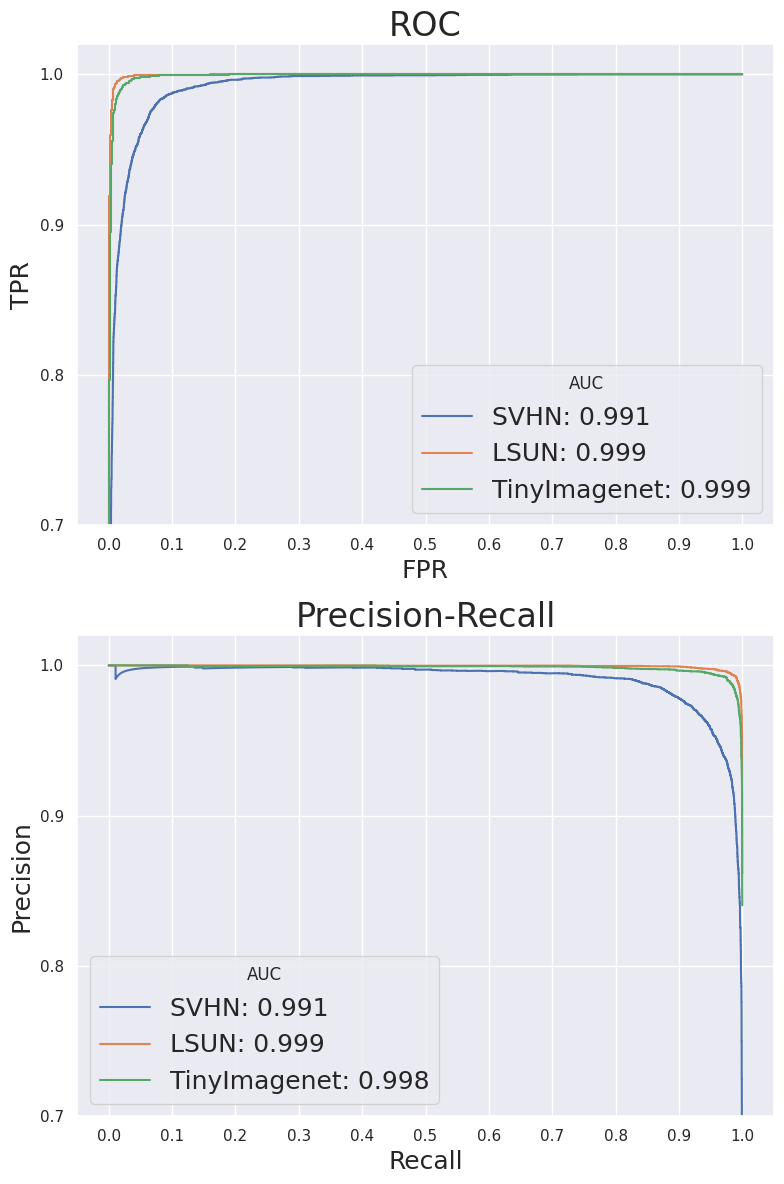

In [156]:
fig, axs = plt.subplots(2,1, figsize=(8,12))
for idx in test_idxs:
    plot_curves(results["KD"]["test_scores"], results["KD"]["ood_scores"][idx], label=LABELS[idx+2], axs=axs)

for ax in axs:
    ax.legend(title="AUC")
    ax.set(ylim=(0.7, 1.02))
plt.tight_layout()
plt.savefig("./kd_curves.png", dpi=200)

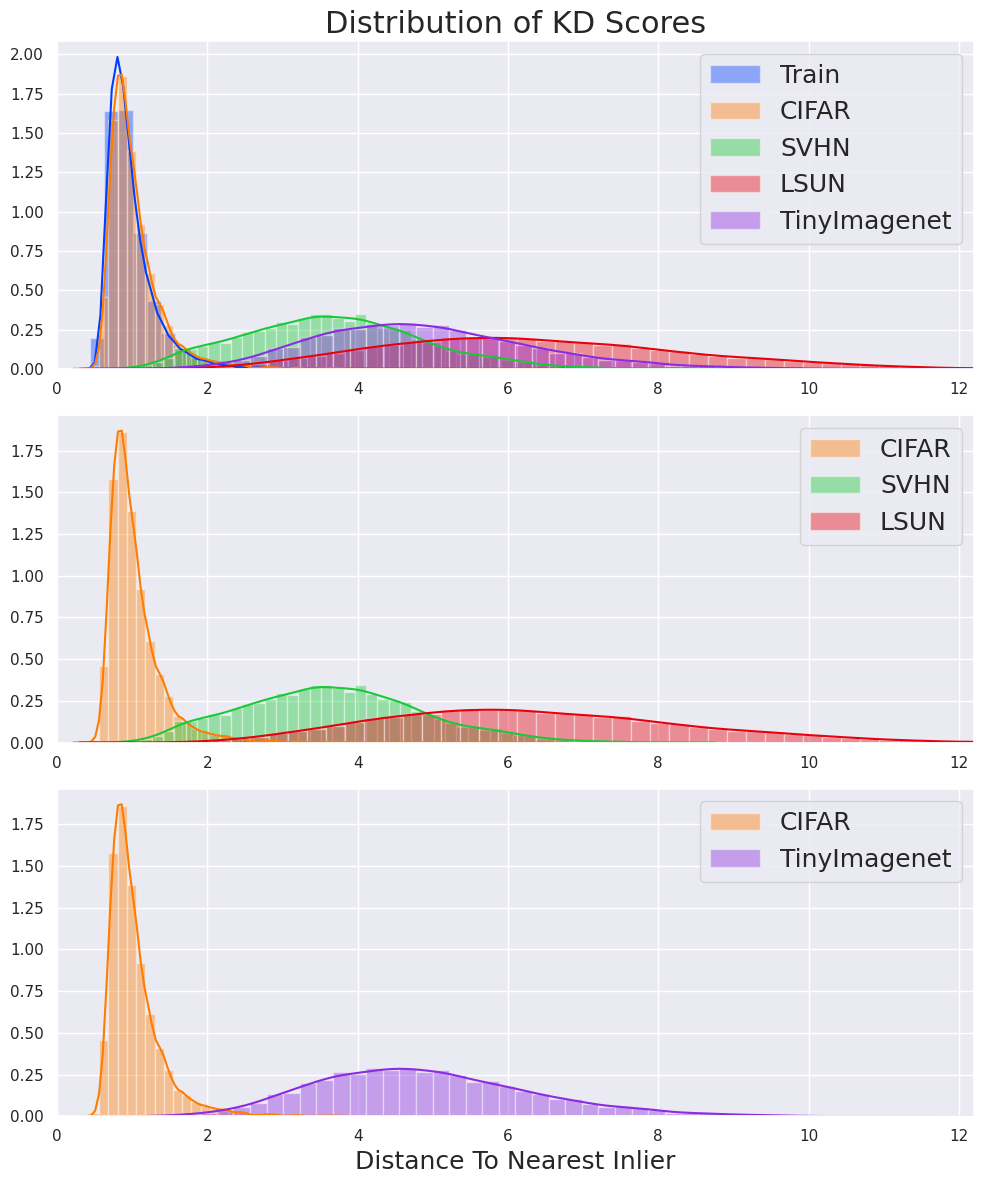

In [146]:
axs = evaluate_model(results["KD"]["train_scores"], results["KD"]["test_scores"],
               np.array(results["KD"]["ood_scores"])[test_idxs], labels=LABELS[label_idxs])

for ax in axs:
    ax.set(xlim = (0,12.2))

axs[0].set(
    title=r"Distribution of KD Scores",
)
axs[-1].set(
    xlabel="Distance To Nearest Inlier"
)
plt.legend()
plt.tight_layout()
plt.savefig("./kd_scores.png", dpi=200)

## GMM vs Flow vs K-NN Tree on CIFAR vs Any

CIFAR vs SVHN
----------------
ROC-AUC: 99.4791
PR-AUC (In/Out): 99.9322 / 97.1087
FPR (95% TPR): 3.73%
Detection Error: 4.24%
CIFAR vs SVHN
----------------
ROC-AUC: 99.5473
PR-AUC (In/Out): 99.9407 / 97.5845
FPR (95% TPR): 3.23%
Detection Error: 3.68%
CIFAR vs SVHN
----------------
ROC-AUC: 99.8297
PR-AUC (In/Out): 99.9773 / 98.9755
FPR (95% TPR): 0.57%
Detection Error: 1.81%


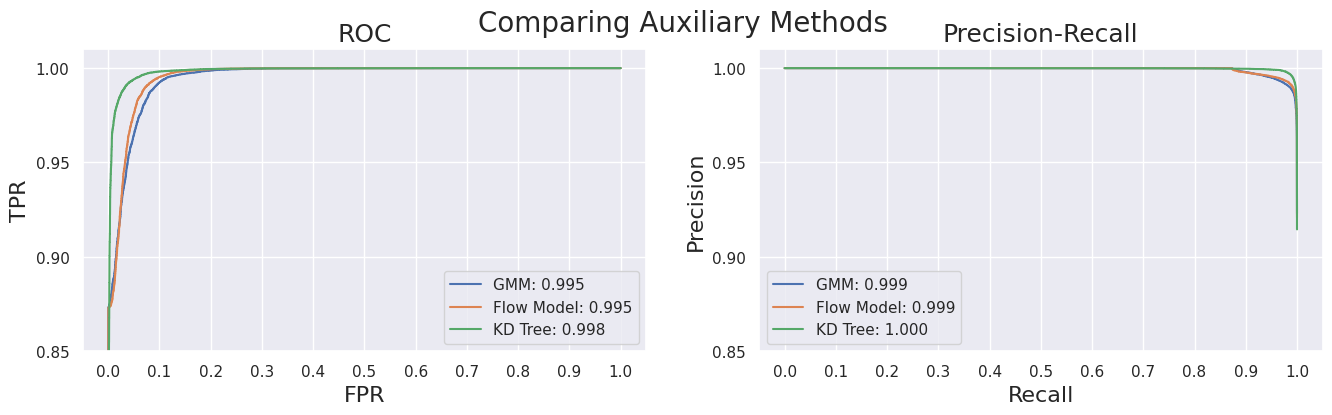

In [114]:
gmm_all = np.concatenate(-results["GMM"]["ood_scores"][1:-1])
flow_all = np.concatenate(-results["Flow"]["ood_scores"][1:-1])
kd_all = np.concatenate(results["KD"]["ood_scores"][1:-1])

pairs = zip(
    ["GMM", "Flow Model", "KD Tree"],
    [-results["GMM"]["test_scores"], -results["Flow"]["test_scores"], results["KD"]["test_scores"]],
    [gmm_all, flow_all, kd_all]
)

fig, axs = plt.subplots(1,2, figsize=(16,4))

for title, cifar_scores, svhn_scores in pairs:
    ood_metrics(cifar_scores, svhn_scores, names=("CIFAR", "SVHN"),plot=False, verbose=True)
    plot_curves(cifar_scores, svhn_scores, title, axs)

for ax in axs:
    ax.set(ylim=(0.85, 1.01), yticks=np.arange(0.85, 1.01, step=0.05))
# axs[1].set(ylim=(0.8, 1.01))

plt.suptitle("Comparing Auxiliary Methods",  fontsize=20)
plt.savefig("./aux.png", dpi=200)